In [1]:
%matplotlib inline


# Second-level fMRI model: true positive proportion in clusters

This script showcases the so-called Notip procedure, in
which the proportion of true discoveries in arbitrary clusters is estimated.
The clusters can be defined from the input image, i.e. in a circular way, as
the error control accounts for arbitrary cluster selection.

Blain, Alexandre, Bertrand Thirion, and Pierre Neuvial. "Notip: Non-parametric True Discovery Proportion control for brain imaging." NeuroImage 260 (2022): 119492. doi:10.1016/j.neuroimage.2022.119492


## Fetch dataset
We download a list of left vs right button press contrasts from a
localizer dataset. Note that we fetch individual t-maps that represent the
BOLD activity estimate divided by the uncertainty about this estimate.



In [2]:
from nilearn.datasets import fetch_localizer_contrasts

n_subjects = 16
data = fetch_localizer_contrasts(
    ["left vs right button press"],
    n_subjects,
    get_tmaps=True,
    legacy_format=False,
)

In [3]:
from nilearn.input_data import NiftiMasker
smoothing_fwhm = 8.0
nifti_masker = NiftiMasker(smoothing_fwhm=smoothing_fwhm)

/home/alex/.local/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [4]:
fmri_input = nifti_masker.fit_transform(data["cmaps"])

## Estimate second level model
We define the input maps and the design matrix for the second level model
and fit it.



In [5]:
import pandas as pd

second_level_input = data["cmaps"]
design_matrix = pd.DataFrame(
    [1] * len(second_level_input), columns=["intercept"]
)

Model specification and fit



In [6]:
from nilearn.glm.second_level import SecondLevelModel

second_level_model = SecondLevelModel(smoothing_fwhm=smoothing_fwhm)
second_level_model = second_level_model.fit(
    second_level_input, design_matrix=design_matrix
)

/home/alex/.local/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


To estimate the contrast is very simple. We can just provide the column
name of the design matrix.



In [7]:
z_map = second_level_model.compute_contrast(output_type="z_score")

Let's extract a cluster of interest:

In [8]:
import numpy as np
from scipy import ndimage
from nilearn._utils.niimg import _safe_get_data

stat_threshold = 4

conn_mat = np.zeros((3, 3, 3), int)
conn_mat[1, 1, :] = 1
conn_mat[1, :, 1] = 1
conn_mat[:, 1, 1] = 1

stat_map = _safe_get_data(z_map, ensure_finite=True)


binarized = stat_map > stat_threshold
binarized = binarized.astype(int)

label_map = ndimage.measurements.label(binarized, conn_mat)[0]

cluster_mask = label_map == 1 # First cluster

In [27]:
cluster_mask.shape

(53, 63, 46)

In [25]:
53 * 63 * 46

153594

In [28]:
np.count_nonzero(cluster_mask)

319

0.9749216300940439


/home/alex/.local/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


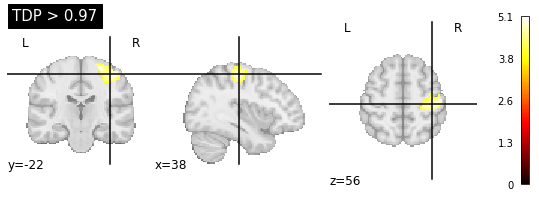

In [9]:
from posthoc_fmri import get_tdp_bound_notip
get_tdp_bound_notip(z_map, fmri_input, cluster_mask)